In [2]:
!pip install pystac_client planetary_computer odc.stac rioxarray rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 68.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.8/153.8 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.2/194.2 kB 18.5 MB/s eta 0:00:00


In [ ]:
########################################################
# 1. IMPORT LIBRARIES
########################################################
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# GIS Libraries
import geopandas as gpd
from shapely.geometry import Point

# Planetary Computer / STAC Libraries
import pystac_client
import planetary_computer
from odc.stac import stac_load

import xarray as xr
import rioxarray
import rasterio

# ML libraries
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

########################################################
# 2. LOAD AND CLEAN UHI DATA
########################################################

# REPLACE with the actual path or URL of your UHI dataset
uhi_csv_path = "uhi.csv"
uhi_df = pd.read_csv(uhi_csv_path)

print("Initial UHI dataset columns:", uhi_df.columns)
print("UHI dataset shape before cleaning:", uhi_df.shape)

# Example: Suppose your CSV has columns: "Longitude", "Latitude", "datetime", "UHI Index"
# Check column names; rename if needed. For demonstration, assume they're correct.

# Check missing values
print(uhi_df.isnull().sum(), "\n")

# Drop duplicates (if time-based duplicates exist):
if set(["Longitude","Latitude","datetime"]).issubset(uhi_df.columns):
    uhi_df.drop_duplicates(subset=["Longitude", "Latitude", "datetime"], inplace=True)

# Drop rows with missing UHI Index
uhi_df.dropna(subset=["UHI Index"], inplace=True)

print("Cleaned UHI data shape:", uhi_df.shape)
print(uhi_df.head(), "\n")

########################################################
# 3. LOAD AND PROCESS WEATHER DATA
########################################################

# Suppose our CSV has columns:
# "Date / Time", "Air Temp at Surface [degC]", "Relative Humidity [percent]",
# "Avg Wind Speed [m/s]", "Wind Direction [degrees]", "Solar Flux [W/m^2]"
weather_csv = "nyc_mesonet_weather.csv"
weather_df = pd.read_csv(weather_csv)

print("Weather columns before rename:", weather_df.columns)

# Rename to simpler columns
weather_df.rename(columns={
    "Date / Time": "datetime",
    "Air Temp at Surface [degC]": "temperature",
    "Relative Humidity [percent]": "humidity",
    "Avg Wind Speed [m/s]": "wind_speed",
    "Wind Direction [degrees]": "wind_dir",
    "Solar Flux [W/m^2]": "solar_flux"
}, inplace=True)

weather_df["datetime"] = pd.to_datetime(weather_df["datetime"])

# Filter for 24 July 2021, 3:00 pm to 4:00 pm
start_time = pd.to_datetime("2021-07-24 15:00:00")
end_time   = pd.to_datetime("2021-07-24 16:00:00")
mask = (weather_df["datetime"] >= start_time) & (weather_df["datetime"] < end_time)
weather_3_4pm = weather_df[mask]

# Average over that hour
weather_avg = weather_3_4pm[["temperature","humidity","wind_speed","wind_dir","solar_flux"]].mean(numeric_only=True)
print("\nWeather averages for 3-4 pm on 2021-07-24:")
print(weather_avg, "\n")

# We'll store these as single city-wide values
citywide_temp = weather_avg["temperature"]
citywide_hum  = weather_avg["humidity"]
citywide_wind = weather_avg["wind_speed"]
citywide_dir  = weather_avg["wind_dir"]
citywide_solar= weather_avg["solar_flux"]

########################################################
# 4. LOAD BUILDING FOOTPRINTS AND COMPUTE COVERAGE
#    (Using SPATIAL INDEX for faster queries)
########################################################

buildings_path = "Building_Footprint.kml"  # or .shp, .kml, etc.
buildings_gdf = gpd.read_file(buildings_path)
print("Number of building footprints loaded:", len(buildings_gdf))

# Ensure CRS is EPSG:4326 before reprojecting
if buildings_gdf.crs != "EPSG:4326":
    buildings_gdf = buildings_gdf.to_crs("EPSG:4326")

# Reproject once to EPSG:2263 for better distance buffering
buildings_local = buildings_gdf.to_crs("EPSG:2263")

# Create a spatial index
buildings_local_sindex = buildings_local.sindex

# Convert UHI data to a GeoDataFrame in EPSG:4326
geometry_pts = [Point(lon, lat) for lon, lat in zip(uhi_df["Longitude"], uhi_df["Latitude"])]
uhi_gdf = gpd.GeoDataFrame(uhi_df, geometry=geometry_pts, crs="EPSG:4326")

def calc_building_coverage_local(point_local, buildings_local, buildings_sindex, radius=100):
    """
    Returns fraction of building coverage in a given radius (meters) around a point.
    Assumes point_local is in EPSG:2263, buildings_local is in EPSG:2263,
    and we have a pre-built spatial index (R-tree).
    """
    # Buffer the point by 'radius' meters
    buffer_poly = point_local.buffer(radius).geometry.iloc[0]

    # Use the bounding box of buffer to query the spatial index
    minx, miny, maxx, maxy = buffer_poly.bounds
    candidate_idx = list(buildings_sindex.intersection((minx, miny, maxx, maxy)))

    if not candidate_idx:
        return 0.0

    candidate_buildings = buildings_local.iloc[candidate_idx]
    # Final clip
    buildings_clip = candidate_buildings.clip(gpd.GeoSeries([buffer_poly], crs=buildings_local.crs))

    total_area = buffer_poly.area
    if len(buildings_clip) == 0:
        return 0.0
    building_area = buildings_clip.geometry.area.sum()
    coverage_ratio = building_area / total_area
    return coverage_ratio

# Loop over each UHI point, reproject the single point to EPSG:2263, compute coverage
cover_values = []
for i, row in uhi_gdf.iterrows():
    point_local = gpd.GeoDataFrame(index=[0], crs="EPSG:4326", geometry=[row.geometry]).to_crs("EPSG:2263")
    cov = calc_building_coverage_local(point_local, buildings_local, buildings_local_sindex, radius=100)
    cover_values.append(cov)

uhi_df["building_cov_100m"] = cover_values

print("\nSample rows after building coverage:")
print(uhi_df[["Longitude","Latitude","building_cov_100m"]].head(), "\n")

########################################################
# 5. LOAD SENTINEL-2 DATA AND EXTRACT NDVI
########################################################

stac = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

# Define bounding box
lower_left = (40.75, -74.01)
upper_right = (40.88, -73.86)
bounds = (lower_left[1], lower_left[0], upper_right[1], upper_right[0])

# Define time window (June - August 2021)
time_window = "2021-06-01/2021-09-01"

search = stac.search(
    bbox=bounds,
    datetime=time_window,
    collections=["sentinel-2-l2a"],
    query={"eo:cloud_cover": {"lt": 30}},
)

items = list(search.get_items())
print("Number of Sentinel-2 scenes found:", len(items))

# Sign items (do NOT convert to dict)
signed_items = [planetary_computer.sign(item) for item in items]

# For demonstration, pick a resolution ~10m in degrees
resolution_m = 10
scale = resolution_m / 111320.0

bands_of_interest = ["B02", "B03", "B04", "B08"]  # Blue, Green, Red, NIR
data = stac_load(
    signed_items,
    bands=bands_of_interest,
    crs="EPSG:4326",
    resolution=scale,
    chunks={"x": 2048, "y": 2048},
    dtype="uint16",
    patch_url=planetary_computer.sign,
    bbox=bounds
)

# Persist to speed up repeated access
data = data.persist()

# For simplicity, pick time=7 (replace with logic to find 24 July if needed)
single_date_data = data.isel(time=7)
single_date_data = single_date_data.persist()

# Scale factor for reflectance
scale_factor = 1/10000.0
red = single_date_data["B04"] * scale_factor
nir = single_date_data["B08"] * scale_factor

# Compute NDVI
ndvi = (nir - red) / (nir + red)
ndvi_rio = ndvi.rio.write_crs("EPSG:4326")

# Extract NDVI for each UHI point
ndvi_values = []
for i, row in uhi_df.iterrows():
    lat, lon = row["Latitude"], row["Longitude"]
    ndvi_val = ndvi_rio.sel(longitude=lon, latitude=lat, method="nearest").values.item()
    ndvi_values.append(ndvi_val)

uhi_df["ndvi"] = ndvi_values

print("\nSample rows after adding NDVI:")
print(uhi_df[["Longitude","Latitude","ndvi"]].head(), "\n")

########################################################
# 6. COMBINE WEATHER FEATURES
########################################################

# Single city-wide averages for 3-4 pm
uhi_df["avg_temp_3_4pm"]  = citywide_temp
uhi_df["avg_hum_3_4pm"]   = citywide_hum
uhi_df["avg_wind_3_4pm"]  = citywide_wind
uhi_df["avg_dir_3_4pm"]   = citywide_dir
uhi_df["avg_solar_3_4pm"] = citywide_solar

print("Final columns in UHI DataFrame:")
print(uhi_df.columns, "\n")

########################################################
# 7. TRAIN A SIMPLE RANDOM FOREST (NO LAT/LON)
########################################################

# DO NOT include "Longitude" or "Latitude" in features
feature_cols = [
    "ndvi",
    "building_cov_100m",
    "avg_temp_3_4pm",
    "avg_hum_3_4pm",
    "avg_wind_3_4pm",
    "avg_dir_3_4pm",
    "avg_solar_3_4pm"
]
target_col = "UHI Index"

X = uhi_df[feature_cols].copy()
y = uhi_df[target_col].copy()

# Simple train/validation split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Train size: {len(X_train)}; Validation size: {len(X_val)}")

rf = RandomForestRegressor(n_estimators=100, max_depth=10, n_jobs=-1, random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_val)

# Compute MSE, then RMSE manually (instead of using squared=False)
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
r2   = r2_score(y_val, y_pred)

print(f"\nRandom Forest Validation RMSE: {rmse:.3f}")
print(f"Random Forest Validation R^2:  {r2:.3f}")


########################################################
# 8. PREDICT ON A NEW VALIDATION DATASET AND SAVE CSV
########################################################

# Suppose the challenge provides a CSV: "NYC_UHI_validation.csv"
# with columns: Longitude, Latitude, UHI Index (empty).
val_csv_path = "NYC_UHI_validation.csv"
val_df = pd.read_csv(val_csv_path)

# 8.1. Generate the same features for the validation data
# (a) Compute building coverage
val_gdf = gpd.GeoDataFrame(val_df, geometry=[
    Point(lon, lat) for lon, lat in zip(val_df["Longitude"], val_df["Latitude"])
], crs="EPSG:4326")

# Reproject buildings once (already done above: buildings_local, buildings_local_sindex)
coverage_vals = []
for i, row in val_gdf.iterrows():
    pt_local = gpd.GeoDataFrame(index=[0], crs="EPSG:4326", geometry=[row.geometry]).to_crs("EPSG:2263")
    cov = calc_building_coverage_local(pt_local, buildings_local, buildings_local_sindex, radius=100)
    coverage_vals.append(cov)

val_df["building_cov_100m"] = coverage_vals

# (b) Compute NDVI in same manner
ndvi_vals = []
for i, row in val_df.iterrows():
    lat, lon = row["Latitude"], row["Longitude"]
    val_ = ndvi_rio.sel(longitude=lon, latitude=lat, method="nearest").values.item()
    ndvi_vals.append(val_)

val_df["ndvi"] = ndvi_vals

# (c) Add the same weather features
val_df["avg_temp_3_4pm"]  = citywide_temp
val_df["avg_hum_3_4pm"]   = citywide_hum
val_df["avg_wind_3_4pm"]  = citywide_wind
val_df["avg_dir_3_4pm"]   = citywide_dir
val_df["avg_solar_3_4pm"] = citywide_solar

# 8.2. Create the feature matrix for the validation data (excluding lat/lon)
X_test = val_df[feature_cols]

# 8.3. Predict
preds = rf.predict(X_test)

# 8.4. Fill the "UHI Index" column with predicted values
val_df["UHI Index"] = preds

# 8.5. Save CSV with the updated predictions
val_df.to_csv("my_prediction.csv", index=False)

print("\nSaved final predictions to 'my_prediction.csv'.")
print("Sample of predicted validation data:")
print(val_df.head(10))


Initial UHI dataset columns: Index(['Longitude', 'Latitude', 'datetime', 'UHI Index'], dtype='object')
UHI dataset shape before cleaning: (11269, 4)
Longitude    0
Latitude     0
datetime     0
UHI Index    0
dtype: int64 

Cleaned UHI data shape: (11234, 4)
   Longitude   Latitude          datetime  UHI Index
0 -73.919037  40.814292  24-07-2021 15:53   1.034616
1 -73.918978  40.814365  24-07-2021 15:53   1.028125
2 -73.918927  40.814433  24-07-2021 15:53   1.028125
3 -73.918875  40.814500  24-07-2021 15:53   1.025961
4 -73.918827  40.814560  24-07-2021 15:53   1.025961 

Weather columns before rename: Index(['Date / Time', 'Air Temp at Surface [degC]',
       'Relative Humidity [percent]', 'Avg Wind Speed [m/s]',
       'Wind Direction [degrees]', 'Solar Flux [W/m^2]'],
      dtype='object')

Weather averages for 3-4 pm on 2021-07-24:
temperature     27.516667
humidity        44.458333
wind_speed       3.125000
wind_dir       132.666667
solar_flux     454.916667
dtype: float64 

Numbe

Initial UHI dataset columns: Index(['Longitude', 'Latitude', 'datetime', 'UHI Index'], dtype='object')
UHI dataset shape before cleaning: (11269, 4)
Longitude    0
Latitude     0
datetime     0
UHI Index    0
dtype: int64 

Cleaned UHI data shape: (11234, 4)
   Longitude   Latitude          datetime  UHI Index
0 -73.919037  40.814292  24-07-2021 15:53   1.034616
1 -73.918978  40.814365  24-07-2021 15:53   1.028125
2 -73.918927  40.814433  24-07-2021 15:53   1.028125
3 -73.918875  40.814500  24-07-2021 15:53   1.025961
4 -73.918827  40.814560  24-07-2021 15:53   1.025961 

Weather columns before rename: Index(['Date / Time', 'Air Temp at Surface [degC]',
       'Relative Humidity [percent]', 'Avg Wind Speed [m/s]',
       'Wind Direction [degrees]', 'Solar Flux [W/m^2]'],
      dtype='object')

Weather averages for 3-4 pm on 2021-07-24:
temperature     27.516667
humidity        44.458333
wind_speed       3.125000
wind_dir       132.666667
solar_flux     454.916667
dtype: float64 

Numbe

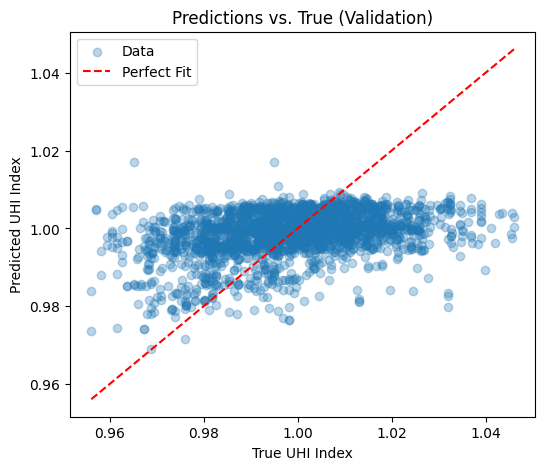

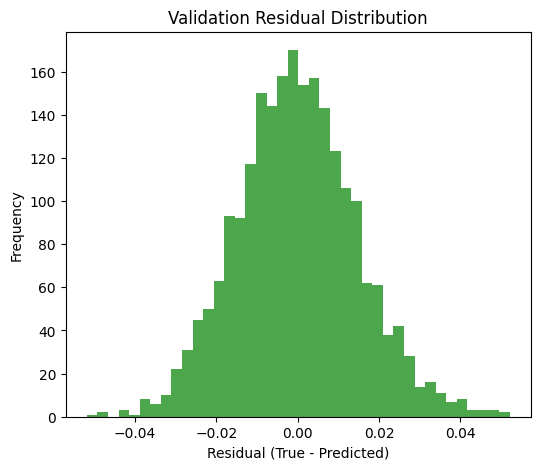


All metrics computed and plots generated!


In [4]:
########################################################
# 1. IMPORT LIBRARIES
########################################################
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# GIS Libraries
import geopandas as gpd
from shapely.geometry import Point

# Planetary Computer / STAC Libraries
import pystac_client
import planetary_computer
from odc.stac import stac_load

import xarray as xr
import rioxarray
import rasterio

# ML libraries
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, make_scorer

########################################################
# 2. LOAD AND CLEAN UHI DATA
########################################################

# Replace these with your actual file paths
uhi_csv_path = "uhi.csv"
uhi_df = pd.read_csv(uhi_csv_path)

print("Initial UHI dataset columns:", uhi_df.columns)
print("UHI dataset shape before cleaning:", uhi_df.shape)

# Check for missing values
print(uhi_df.isnull().sum(), "\n")

# Drop duplicates if time-based duplicates exist
if set(["Longitude", "Latitude", "datetime"]).issubset(uhi_df.columns):
    uhi_df.drop_duplicates(subset=["Longitude", "Latitude", "datetime"], inplace=True)

# Drop rows missing UHI Index
uhi_df.dropna(subset=["UHI Index"], inplace=True)

print("Cleaned UHI data shape:", uhi_df.shape)
print(uhi_df.head(), "\n")

########################################################
# 3. LOAD AND PROCESS WEATHER DATA
########################################################

weather_csv = "nyc_mesonet_weather.csv"
weather_df = pd.read_csv(weather_csv)

print("Weather columns before rename:", weather_df.columns)

# Rename to simpler columns
weather_df.rename(columns={
    "Date / Time": "datetime",
    "Air Temp at Surface [degC]": "temperature",
    "Relative Humidity [percent]": "humidity",
    "Avg Wind Speed [m/s]": "wind_speed",
    "Wind Direction [degrees]": "wind_dir",
    "Solar Flux [W/m^2]": "solar_flux"
}, inplace=True)

weather_df["datetime"] = pd.to_datetime(weather_df["datetime"])

# Filter for a specific time window (24 July 2021, 3–4 pm)
start_time = pd.to_datetime("2021-07-24 15:00:00")
end_time   = pd.to_datetime("2021-07-24 16:00:00")
mask = (weather_df["datetime"] >= start_time) & (weather_df["datetime"] < end_time)
weather_3_4pm = weather_df[mask]

# Take mean for that hour
weather_avg = weather_3_4pm[["temperature","humidity","wind_speed","wind_dir","solar_flux"]].mean(numeric_only=True)
print("\nWeather averages for 3-4 pm on 2021-07-24:")
print(weather_avg, "\n")

citywide_temp = weather_avg["temperature"]
citywide_hum  = weather_avg["humidity"]
citywide_wind = weather_avg["wind_speed"]
citywide_dir  = weather_avg["wind_dir"]
citywide_solar= weather_avg["solar_flux"]

########################################################
# 4. LOAD BUILDING FOOTPRINTS & CALCULATE COVERAGE
########################################################

buildings_path = "Building_Footprint.kml"
buildings_gdf = gpd.read_file(buildings_path)
print("Number of building footprints loaded:", len(buildings_gdf))

if buildings_gdf.crs != "EPSG:4326":
    buildings_gdf = buildings_gdf.to_crs("EPSG:4326")

# Reproject once to a local meter-based CRS
buildings_local = buildings_gdf.to_crs("EPSG:2263")
buildings_local_sindex = buildings_local.sindex

# Convert UHI to GeoDataFrame
geometry_pts = [Point(lon, lat) for lon, lat in zip(uhi_df["Longitude"], uhi_df["Latitude"])]
uhi_gdf = gpd.GeoDataFrame(uhi_df, geometry=geometry_pts, crs="EPSG:4326")

def calc_building_coverage_local(point_local, buildings_local, buildings_sindex, radius=100):
    """
    Returns fraction of building coverage in radius (meters) around a point.
    """
    # Buffer the point
    buffer_poly = point_local.buffer(radius).geometry.iloc[0]

    # Spatial index to find candidate footprints
    minx, miny, maxx, maxy = buffer_poly.bounds
    candidate_idx = list(buildings_sindex.intersection((minx, miny, maxx, maxy)))
    if not candidate_idx:
        return 0.0

    candidate_buildings = buildings_local.iloc[candidate_idx]
    buildings_clip = candidate_buildings.clip(gpd.GeoSeries([buffer_poly], crs=buildings_local.crs))

    total_area = buffer_poly.area
    if len(buildings_clip) == 0:
        return 0.0
    building_area = buildings_clip.geometry.area.sum()
    coverage_ratio = building_area / total_area
    return coverage_ratio

cover_values = []
for i, row in uhi_gdf.iterrows():
    point_local = gpd.GeoDataFrame(index=[0], crs="EPSG:4326", geometry=[row.geometry]).to_crs("EPSG:2263")
    cov = calc_building_coverage_local(point_local, buildings_local, buildings_local_sindex, radius=100)
    cover_values.append(cov)

uhi_df["building_cov_100m"] = cover_values

print("\nSample rows after building coverage:")
print(uhi_df[["Longitude","Latitude","building_cov_100m"]].head(), "\n")

########################################################
# 5. LOAD SENTINEL-2 DATA AND EXTRACT NDVI
########################################################

stac = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

# Define bounding box (min_lon, min_lat, max_lon, max_lat)
lower_left = (40.75, -74.01)
upper_right = (40.88, -73.86)
bounds = (lower_left[1], lower_left[0], upper_right[1], upper_right[0])

time_window = "2021-06-01/2021-09-01"

search = stac.search(
    bbox=bounds,
    datetime=time_window,
    collections=["sentinel-2-l2a"],
    query={"eo:cloud_cover": {"lt": 30}},
)

items = list(search.get_items())
print("Number of Sentinel-2 scenes found:", len(items))

signed_items = [planetary_computer.sign(item) for item in items]

resolution_m = 10
scale = resolution_m / 111320.0

bands_of_interest = ["B02", "B03", "B04", "B08"]  # Blue, Green, Red, NIR
data = stac_load(
    signed_items,
    bands=bands_of_interest,
    crs="EPSG:4326",
    resolution=scale,
    chunks={"x": 2048, "y": 2048},
    dtype="uint16",
    patch_url=planetary_computer.sign,
    bbox=bounds
)
data = data.persist()

# Pick a single date index (e.g., time=7) for demonstration
single_date_data = data.isel(time=7).persist()

# Scale factor
scale_factor = 1/10000.0
red = single_date_data["B04"] * scale_factor
nir = single_date_data["B08"] * scale_factor

# NDVI
ndvi = (nir - red) / (nir + red)
ndvi_rio = ndvi.rio.write_crs("EPSG:4326")

# Extract NDVI for each point
ndvi_values = []
for i, row in uhi_df.iterrows():
    lat, lon = row["Latitude"], row["Longitude"]
    val = ndvi_rio.sel(longitude=lon, latitude=lat, method="nearest").values.item()
    ndvi_values.append(val)

uhi_df["ndvi"] = ndvi_values

print("\nSample rows after adding NDVI:")
print(uhi_df[["Longitude","Latitude","ndvi"]].head(), "\n")

########################################################
# 6. COMBINE WEATHER FEATURES
########################################################

uhi_df["avg_temp_3_4pm"]  = citywide_temp
uhi_df["avg_hum_3_4pm"]   = citywide_hum
uhi_df["avg_wind_3_4pm"]  = citywide_wind
uhi_df["avg_dir_3_4pm"]   = citywide_dir
uhi_df["avg_solar_3_4pm"] = citywide_solar

print("Final columns in UHI DataFrame:")
print(uhi_df.columns, "\n")

########################################################
# 7. SPLIT DATA, TRAIN MODEL, AND CALCULATE METRICS
########################################################

# DO NOT include Longitude/Latitude in your final model
feature_cols = [
    "ndvi",
    "building_cov_100m",
    "avg_temp_3_4pm",
    "avg_hum_3_4pm",
    "avg_wind_3_4pm",
    "avg_dir_3_4pm",
    "avg_solar_3_4pm"
]
target_col = "UHI Index"

X = uhi_df[feature_cols].copy()
y = uhi_df[target_col].copy()

# Train-validation split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Train size: {len(X_train)}; Validation size: {len(X_val)}")

# Train a Random Forest
rf = RandomForestRegressor(n_estimators=100, max_depth=10, n_jobs=-1, random_state=42)
rf.fit(X_train, y_train)

########################################################
# 7.1 METRICS ON TRAIN SET
########################################################
y_pred_train = rf.predict(X_train)
train_mse = mean_squared_error(y_train, y_pred_train)
train_rmse = np.sqrt(train_mse)
train_r2 = r2_score(y_train, y_pred_train)

print(f"\nTRAINING SET METRICS:")
print(f"Train RMSE: {train_rmse:.5f}")
print(f"Train R^2:  {train_r2:.3f}")

########################################################
# 7.2 METRICS ON VALIDATION SET
########################################################
y_pred_val = rf.predict(X_val)
val_mse = mean_squared_error(y_val, y_pred_val)
val_rmse = np.sqrt(val_mse)
val_r2 = r2_score(y_val, y_pred_val)

print(f"\nVALIDATION SET METRICS:")
print(f"Validation RMSE: {val_rmse:.5f}")
print(f"Validation R^2:  {val_r2:.3f}")

########################################################
# 7.3 K-FOLD CROSS-VALIDATION
########################################################

# We'll do 5-fold cross-validation on the entire dataset X, y
def rmse_metric(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse_metric, greater_is_better=False)

kfold = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(rf, X, y, scoring=rmse_scorer, cv=kfold)

# cross_val_score uses negative values for "loss" metrics, so multiply by -1
cv_rmse_scores = -1 * cv_scores
print("\nK-FOLD CROSS-VALIDATION (5-fold)")
print("RMSE per fold:", cv_rmse_scores)
print(f"Mean RMSE: {cv_rmse_scores.mean():.5f}")
print(f"Std  RMSE: {cv_rmse_scores.std():.5f}")

########################################################
# 7.4 VISUALIZE RESULTS (VALIDATION SET)
########################################################

# 1) Scatter: predicted vs. true
plt.figure(figsize=(6,5))
plt.scatter(y_val, y_pred_val, alpha=0.3, label="Data")
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', label="Perfect Fit")
plt.title("Predictions vs. True (Validation)")
plt.xlabel("True UHI Index")
plt.ylabel("Predicted UHI Index")
plt.legend()
plt.show()

# 2) Residual histogram
residuals = y_val - y_pred_val
plt.figure(figsize=(6,5))
plt.hist(residuals, bins=40, alpha=0.7, color='g')
plt.title("Validation Residual Distribution")
plt.xlabel("Residual (True - Predicted)")
plt.ylabel("Frequency")
plt.show()

print("\nAll metrics computed and plots generated!")


In [5]:
# Suppose we have y_val, y_pred_val from the validation set

# === 1) Threshold-based Accuracy ===
threshold = 0.01
within_thresh = np.abs(y_pred_val - y_val) <= threshold
threshold_accuracy = within_thresh.mean()
print(f"Threshold-based Accuracy (±{threshold}): {threshold_accuracy:.2%}")

# === 2) MAPE-based "Accuracy" ===
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(y_val, y_pred_val)
perc_accuracy = 100 - mape
print(f"MAPE: {mape:.2f}% (=> ~{perc_accuracy:.2f}% 'accuracy')")


Threshold-based Accuracy (±0.01): 51.85%
MAPE: 1.17% (=> ~98.83% 'accuracy')
